# Defining and Testing websearching tool

In [1]:
import os
import json
from typing import List, Annotated, TypedDict, Optional
from dotenv import load_dotenv
import logging

# langchain components
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, ToolMessage
from pydantic import BaseModel, Field

#langgraph components
from langgraph.graph import StateGraph, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode

#syntaxing
from rich.console import Console
from rich.markdown import Markdown

load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agentic Architecture - Tool Use"

for key in ["LANGCHAIN_API_KEY", "TAVILY_API_KEY"]:
    if not os.environ.get(key):
        print(f"{key} not found. Please create a .env file and set it.")

logging.basicConfig(
    level="INFO",
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

logging.info("Environment variables loaded and tracing is set up.")

2025-12-29 18:07:26,976 - root - INFO - Environment variables loaded and tracing is set up.


In [2]:
# creating and testing the Web Search Tool
search_tool = TavilySearchResults(max_results=2)
search_tool.name = "web_search"
search_tool.description = "A tool that can be used to search the internet for up-to-date information on any topic, including news, events, and current affairs."
tools = [search_tool]

logging.info(f"Tool '{search_tool}' is created with description: '{search_tool.description}' ")

console = Console()

# Let's test the tool directly to see its output format
print("\n Testing the tool directly")
test_query = "What is the current update of the murder of Hudi in Bangladesh?"
test_result = search_tool.invoke({"query": test_query})

console.print(f"[bold green]Query:[/bold green] {test_query}")
console.print("\n[bold green]Result:[/bold green]")
console.print(test_result)

/tmp/ipykernel_32445/643413224.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=2)
2025-12-29 18:07:26,991 - root - INFO - Tool 'name='web_search' description='A tool that can be used to search the internet for up-to-date information on any topic, including news, events, and current affairs.' max_results=2 api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))' is created with description: 'A tool that can be used to search the internet for up-to-date information on any topic, including news, events, and current affairs.' 



 Testing the tool directly


Query: What is the current update of the murder of Hudi in Bangladesh?

Result:

[
    {
        'title': 'Top news of the day: Two suspects in Sharif Osman Hadi murder ...',
        'url': 'https://www.thehindu.com/news/top-news-of-the-day-december-28-2025/article70446231.ece',
        'content': "Top news of the day: Two suspects in Sharif Osman Hadi murder case fled to India, say 
Bangladesh police; ECI halts hearings for 'unmapped'",
        'score': 0.16450334
    },
    {
        'title': "Bangladesh Police Say Student Leader's Killers Fled to India",
        'url': 'https://www.youtube.com/watch?v=4jRVARkytpo',
        'content': '... death set off violent protests with angry mobs torching several ... India Bangladesh War 
Threat Explodes Overnight | Indian Defence News | Latest',
        'score': 0.09302524
    }
]

# Building the Tool-Using Agent with LangGraph


In [3]:
## Defining the graph state


from langchain.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

class  AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

logging.info("AgentState TypeDict defined to manage Conversation History")

2025-12-29 18:07:31,583 - root - INFO - AgentState TypeDict defined to manage Conversation History


In [4]:
# Binding tools to the LLM
from langchain_ollama import ChatOllama

llm = ChatOllama(model="qwen3:latest", temperature=0.2)
llm_with_tools = llm.bind_tools(tools)

logging.info("LLM has been bound with the provided tools.")




2025-12-29 18:07:32,062 - root - INFO - LLM has been bound with the provided tools.


In [5]:
# Defining the Agent Nodes
def agent_node(state: AgentState):
    """The primary node that calls the LLM to decide the next action"""
    logging.info("--- AGENT: Thinking... ---")
    response = llm_with_tools.invoke(state["messages"])  
    return {"message":[response]}  

tool_node = ToolNode(tools)

logging.info("Aget node and Tool node have been defined..")

2025-12-29 18:07:32,079 - root - INFO - Aget node and Tool node have been defined..


In [6]:
# Defining the conditional router
def router_function(state: AgentState) -> str:
    """Inspects the agent's last message to decide the next step."""
    last_message = state["messages"][-1]
    
    # For LangGraph with bound tools, check if it's an AI message that might contain tool calls
    if hasattr(last_message, 'type') and last_message.type == 'ai':
        # Check for tool_calls in various possible locations
        if (hasattr(last_message, 'tool_calls') and last_message.tool_calls) or \
           (hasattr(last_message, 'additional_kwargs') and 'tool_calls' in last_message.additional_kwargs):
            console.print("--- ROUTER: Decision is to call a tool. ---")
            return "call_tool"
    
    # Default: finish
    console.print("--- ROUTER: Decision is to finish. ---")
    return "__end__"


print("Router function defined.")

Router function defined.


# Assembling and Running the Workflow

2025-12-29 18:07:32,134 - root - INFO - Tool-using agent graph compiled successfully!


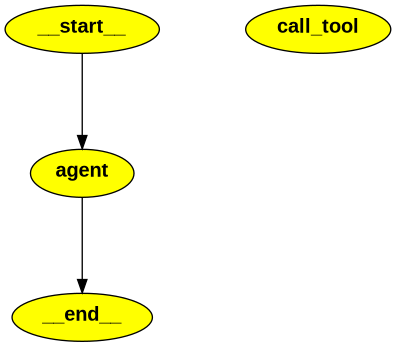

In [7]:
# Building and visualizing the graph
graph_builder = StateGraph(AgentState)

# adding the nodes of the graph
graph_builder.add_node("agent", agent_node)
graph_builder.add_node("call_tool", tool_node)

# building workflow
graph_builder.set_entry_point("agent")
graph_builder.add_conditional_edges(
    'agent',
    router_function,
)
graph_builder.add_edge("call_tool", "agent")
graph_builder.add_edge("agent", END)

#Compile the graph
tool_agent_app = graph_builder.compile()

logging.info("Tool-using agent graph compiled successfully!")

#Visualize the graph
try:
    from IPython.display import Image, display
    png_image = tool_agent_app.get_graph().draw_png()
    display(Image(png_image))
except Exception as e:
    print(f'Graph visualization field: {e}. Please ensure pygraphviz is installed.')

In [13]:
user_query = "What were the main announcements from Apple's latest WWDC event?"
initial_input = {"messages": [("user", user_query)]}

for chunk in tool_agent_app.stream(initial_input, stream_mode="values"):
    chunk["messages"]
    console.print("\n---\n")

console.print("\nTool use workflow completed!")

---

2025-12-29 18:10:24,423 - root - INFO - --- AGENT: Thinking... ---
2025-12-29 18:10:25,260 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


--- ROUTER: Decision is to finish. ---

Tool use workflow completed!